In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import f1_score, recall_score

## Read Data (tokenized)

In [2]:
train_set = pd.read_csv("train_set.csv")
val_set = pd.read_csv("val_set.csv")

train_data = train_set.append([val_set], ignore_index=True)
test_data = pd.read_csv("test_set.csv")

In [3]:
print("There are %s training samples"%len(train_data),"with %s positive matchings"%len(*np.where(train_data["label"]==1)),"and %s negative samples."%len(*np.where(train_data["label"]==0)))
print("There are %s testing samples"%len(test_data),"with %s positive matchings"%len(*np.where(test_data["label"]==1)),"and %s negative samples."%len(*np.where(test_data["label"]==0)))

There are 61198 training samples with 1045 positive matchings and 60153 negative samples.
There are 3487 testing samples with 232 positive matchings and 3255 negative samples.


In [4]:
train_data.head(2)

,similarity,label,amazon_name,google_name,amazon_description,google_description,amazon_info,google_info,price_diff,price_nan_indicator
0,0.14,0,intervideo dvd copy express,fogware hyb art dvd,dvd copy express gives fast dvdcopying filecon...,works ipod g ipod nano windows windows® xp dvd...,intervideo dvd copy express dvd copy express g...,fogware hyb art dvd works ipod g ipod nano win...,0.266756,0
1,0.20,0,instant immersion spanish,spanish know deluxe,instant immersion version moves beginner inter...,spanish learning everyone know manages learnin...,instant immersion spanish instant immersion ve...,spanish know deluxe spanish learning everyone ...,0.634878,0


In [5]:
test_data.head(2)

,similarity,label,amazon_name,google_name,amazon_description,google_description,amazon_info,google_info,price_diff,price_nan_indicator
0,1.00,1,clickart premier image pack dvdrom,clickart premier image pack dvdrom,,massive collection images fonts design needs o...,clickart premier image pack dvdrom,clickart premier image pack dvdrom massive col...,1.00000,1
1,0.67,1,mias math adventure time,kutoka interactive mias math adventure time,mias math adventure time children help mia sav...,mias math adventure tells captivating story ed...,mias math adventure time mias math adventure t...,kutoka interactive mias math adventure time mi...,0.20008,0


## Text to Value

In [6]:
# Calculate the jaccard distance
def jaccard_distance(str1,str2):
    if not str1.strip() or not str2.strip():
        return 0
    else:
        a = set(str1.split())
        b = set(str2.split())
        c = a.intersection(b)
        jaccard_dist = float(len(c)) / (len(a) + len(b) - len(c))
        return jaccard_dist

In [7]:
train_name_sim = [0]*len(train_data)
train_desc_sim = [0]*len(train_data)
train_name_sim = train_data.apply(lambda x: jaccard_distance(x["amazon_name"],x["google_name"]), axis=1)
train_desc_sim = train_data.apply(lambda x: jaccard_distance(x["amazon_description"],x["google_description"]), axis=1)

test_name_sim = [0]*len(train_data)
test_desc_sim = [0]*len(train_data)
test_name_sim = test_data.apply(lambda x: jaccard_distance(x["amazon_name"],x["google_name"]), axis=1)
test_desc_sim = test_data.apply(lambda x: jaccard_distance(x["amazon_description"],x["google_description"]), axis=1)

In [8]:
transformed_train_1 = pd.DataFrame({"name_similarity":train_name_sim,
                                    "description_similarity":train_desc_sim,
                                    "price_diff":train_data["price_diff"],
                                    "price_nan_ind":train_data["price_nan_indicator"],
                                    "label":train_data["label"]})
transformed_test_1 = pd.DataFrame({"name_similarity":test_name_sim,
                                   "description_similarity":test_desc_sim,
                                   "price_diff":test_data["price_diff"],
                                   "price_nan_ind":test_data["price_nan_indicator"],
                                   "label":test_data["label"]})

In [9]:
transformed_train_1.head(2)

,name_similarity,description_similarity,price_diff,price_nan_ind,label
0,0.142857,0.04878,0.266756,0,0
1,0.200000,0.00000,0.634878,0,0


In [10]:
transformed_test_1.head(2)

,name_similarity,description_similarity,price_diff,price_nan_ind,label
0,1.000000,0.000000,1.00000,1,1
1,0.666667,0.178571,0.20008,0,1


In [11]:
transformed_train_1.to_csv("numeric_train.csv",index=False)
transformed_test_1.to_csv("numeric_test.csv",index=False)

## Data Info

In [12]:
print(transformed_train_1["label"].value_counts())

pos = len(transformed_train_1[transformed_train_1["label"]==1])
neg = len(transformed_train_1[transformed_train_1["label"]==0])
print("The percentage of matching is %s"%round((pos/(pos+neg)*100),2),"%.")
print("The percentage of non-matching is %s"%round((neg/(pos+neg)*100),2),"%.")

0    60153
1     1045
Name: label, dtype: int64
The percentage of matching is 1.71 %.
The percentage of non-matching is 98.29 %.


## Logistic Regression Model

In [13]:
def LogReg(reg_coef=1):
    logreg = LogisticRegression(C=reg_coef)
    return logreg

def lambda_search(X_train, y_train, X_val, y_val):
    lambdas = [1, 10, 100, 1000, 10000]
    f1 = []
    recall = []
    for i in lambdas:
        logreg = LogReg(i)
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_val)
        f1.append(f1_score(y_val, y_pred))
        recall.append(recall_score(y_val, y_pred))
    print(lambdas)    
    print(f1)
    print(recall)
    # x = 1/np.asarray(lambdas)
    plt.plot(lambdas,f1)
    plt.plot(lambdas, recall)

def pr_curve(logreg, X_test, y_test):
    # predict probabilities
    lr_probs = logreg.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    y_hat = logreg.predict(X_test)
    lr_precision, lr_recall, threds = precision_recall_curve(y_test, lr_probs)
    lr_f1, lr_auc = f1_score(y_test, y_hat), auc(lr_recall, lr_precision)
    # summarize scores
    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    return lr_precision, lr_recall

def roc_plot(logreg, X_test, y_test):
    # predict probabilities
    lr_probs = logreg.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    y_probs = lr_probs[:, 1]
    # predict class values
    y_hat = logreg.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label="Logistic Regression")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Logistic Regression ROC Curve")
    plt.legend()
    plt.show()
    return tpr, fpr

def test_model(logreg, X_test, y_test):
    
    y_pred = logreg.predict(X_test)
    print("accuracy = %s"%logreg.score(X_test, y_test))
    print("f1 socre = %s"%f1_score(y_test, y_pred))
    print("recall__ = %s"%recall_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("confusion matrix :")
    print(cm)
    print("classification report :")
    print(classification_report(y_test,y_pred))
    # PR curve
    precision, recall = pr_curve(logreg, X_test, y_test)
    return precision, recall

### Imbalance Original Data

0    48107
1      851
Name: label, dtype: int64
0    12046
1      194
Name: label, dtype: int64
[1, 10, 100, 1000, 10000]
[0.37800687285223367, 0.40939597315436244, 0.40939597315436244, 0.40939597315436244, 0.40939597315436244]
[0.28350515463917525, 0.31443298969072164, 0.31443298969072164, 0.31443298969072164, 0.31443298969072164]


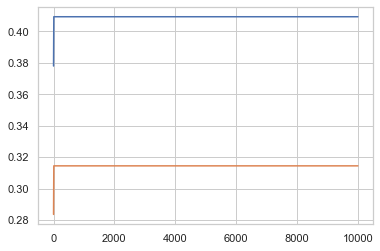

In [14]:
# Split the train and val set
X = transformed_train_1.iloc[:,0:4]
y = transformed_train_1.iloc[:,4]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2) # random_state = 

print(y_train.value_counts())
print(y_val.value_counts())

X_test = transformed_test_1.iloc[:,0:4]
y_test = transformed_test_1.iloc[:,4]

# Shuffle data
X, y = shuffle(X, y)
X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)
X_test, y_test = shuffle(X_test, y_test)

# Select Regularization Coefficient
lambda_search(X_train, y_train, X_val, y_val)

accuracy = 0.9572698594780614
f1 socre = 0.5329153605015674
recall__ = 0.36637931034482757
confusion matrix :
[[3253    2]
 [ 147   85]]
classification report :
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3255
           1       0.98      0.37      0.53       232

    accuracy                           0.96      3487
   macro avg       0.97      0.68      0.76      3487
weighted avg       0.96      0.96      0.95      3487

Logistic: f1=0.533 auc=0.801


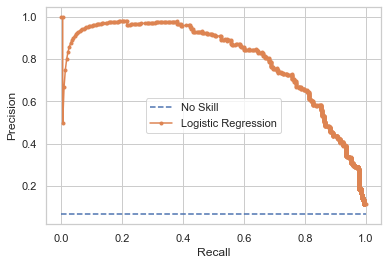

In [15]:
# build a logistic regression model based on train and val data
logreg_imb = LogReg(10)
logreg_imb.fit(X, y)

# Test model on test set
lr_precision, lr_recall = test_model(logreg_imb, X_test, y_test)

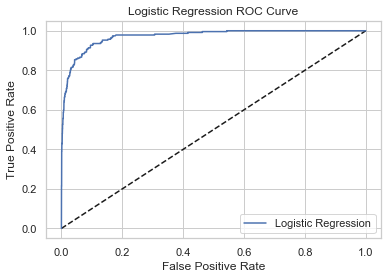

In [20]:
# ROC Curve
tpr, fpr = roc_plot(logreg_imb, X_test, y_test)

### Resampling to Balance Data

In [21]:
negative_index = np.squeeze(np.where(transformed_train_1["label"] == 0))
print("No. of negatives : ",len(negative_index))
negative_samples = transformed_train_1.iloc[negative_index.tolist(),:]

positive_index = np.squeeze(np.where(transformed_train_1["label"] == 1))
print("No. of positives : ",len(positive_index))
positive_samples = transformed_train_1.iloc[positive_index.tolist(),:]
positive_samples = positive_samples.append([positive_samples]*57, ignore_index=True)
print("No. of positives after resampling: ",len(positive_samples))

data_samples = positive_samples.append([negative_samples],ignore_index = True)
data_samples = data_samples.sample(frac=1)
data_samples.head(2)

No. of negatives :  60153
No. of positives :  1045
No. of positives after resampling:  60610


,name_similarity,description_similarity,price_diff,price_nan_ind,label
27863,0.333333,0.081081,0.216216,0,1
90222,0.142857,0.000000,0.367456,0,0


[1, 10, 100, 1000, 10000]
[0.9302612631145856, 0.9308062327837849, 0.9308445029191679, 0.9308445029191679, 0.9308445029191679]
[0.9227064968984655, 0.9239307868103167, 0.9239307868103167, 0.9239307868103167, 0.9239307868103167]


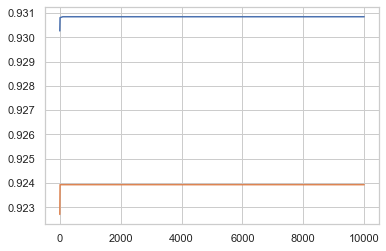

In [22]:
X_re = data_samples.iloc[:,0:4]
y_re = data_samples.iloc[:,4]
X_train_re, X_val_re, y_train_re, y_val_re = train_test_split(X_re, y_re, test_size = 0.2)

# Shuffle data
X_re, y_re = shuffle(X_re, y_re)
X_train_re, y_train_re = shuffle(X_train_re, y_train_re)
X_val_re, y_val_re = shuffle(X_val_re, y_val_re)
X_test, y_test = shuffle(X_test, y_test)

# Select Regularization Coefficient
lambda_search(X_train_re, y_train_re, X_val_re, y_val_re)

accuracy = 0.9392027530828793
f1 socre = 0.6591639871382636
recall__ = 0.8836206896551724
confusion matrix :
[[3070  185]
 [  27  205]]
classification report :
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3255
           1       0.53      0.88      0.66       232

    accuracy                           0.94      3487
   macro avg       0.76      0.91      0.81      3487
weighted avg       0.96      0.94      0.95      3487

Logistic: f1=0.659 auc=0.799


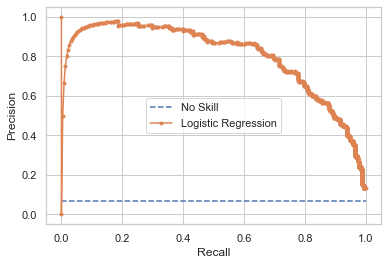

In [23]:
# Build model with reg coef 0.01
logreg_re = LogReg(10)
# Train model on the train and val set
logreg_re.fit(X_re, y_re)

# Test model
lr_precision_re, lr_recall_re = test_model(logreg_re, X_test, y_test)

### SMOTE Oversampling

In [25]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [26]:
print(Counter(y_train))
smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X, y) 
print(Counter(y_over))

Counter({0: 48107, 1: 851})
Counter({0: 60153, 1: 60153})


[1, 10, 100, 1000, 10000]
[0.926468141740143, 0.9269469044946156, 0.9269469044946156, 0.9269469044946156, 0.9269469044946156]
[0.919356170037144, 0.9200990507635163, 0.9200990507635163, 0.9200990507635163, 0.9200990507635163]


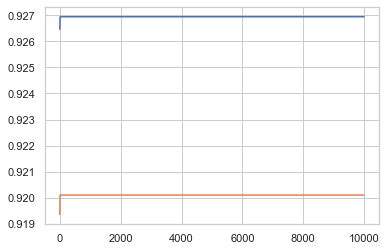

In [27]:
# Split train and val set
X_train_over, X_val_over, y_train_over, y_val_over = train_test_split(X_over, y_over, test_size = 0.2, random_state=0)

# Shuffle data
X_over, y_over = shuffle(X_over, y_over)
X_train_over, y_train_over = shuffle(X_train_over, y_train_over)
X_val_over, y_val_over = shuffle(X_val_over, y_val_over)

# Select Regularization Coefficient
lambda_search(X_train_over, y_train_over, X_val_over, y_val_over)

accuracy = 0.9389159736162891
f1 socre = 0.6570048309178744
recall__ = 0.8793103448275862
confusion matrix :
[[3070  185]
 [  28  204]]
classification report :
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3255
           1       0.52      0.88      0.66       232

    accuracy                           0.94      3487
   macro avg       0.76      0.91      0.81      3487
weighted avg       0.96      0.94      0.95      3487

Logistic: f1=0.657 auc=0.799


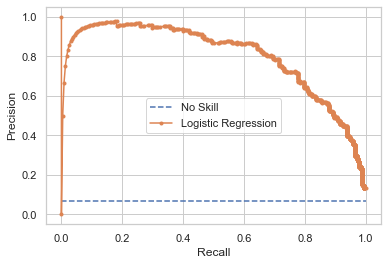

In [28]:
# Build model with reg coef 0.01
logreg_over = LogReg(10)
# Train model on the train and val set
logreg_over.fit(X_over, y_over)

# Test model
lr_precision_over, lr_recall_over = test_model(logreg_over, X_test, y_test)

In [29]:
import pickle

filename = 'LR_model.sav'
pickle.dump(logreg_re, open(filename, 'wb'))